# Tyssue Implementation of Lan et al. (2015)

Siang Lim (siang@alumni.ubc.ca)

---
Changelog:

v0.04 - Fixed NaN errors and added upcast/downcast methods

v0.03 - Adding differential equations and Runge-Kutta 2nd order solver

v0.02 - Automated vertex generation and edge connectivity algorithm for 2D cells. Got an error with get_extra_indices().

v0.01 - First try



In [34]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tyssue as ty

from tyssue.core.sheet import Sheet
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import sheet_view
from tyssue.utils.utils import _to_2d, _to_3d

from lan_sheet import multi_faces_sheet
from lan_geom import LanGeometry

---

### Model Settings Goes in Here

In [35]:
# Kinetic Parameters
qr = 0.02 #s-1
qb = 0.02 #s-1
k1 = 0.67 #s-1
k2 = 0.60 #s-1     #called km in old code 
k3 = 0.27 #s-1
k4 = 4.02 #nN-1
kr = 0.05 #s-1    #called ksh in old code
kb = 0.05 #s-1    #called kb1 in old code

# Biochemistry at Quasi-Steady State
Seq  = 0.5
Req  = qr/(kr*np.exp(-Seq))
Beq  = qb/(kb*Req)
Meq  = (k1*Req)/(k3 + k2*Beq)

# Mechanical Parameters
Am = 1.0 #0.50 0.10 # Myosin amplitude 
period = 147 #20 #147 #s
beta = 0.324 #nN
eta = 4.63 #4.64 #nNs/um
miu = 0.031 #nN/um
K_cor = 0.1
tau_pre = 0.1
alpha = 0.05 #nN/um2 #alpha
restLength = 1.0
restArea = 41.57

Total Vertices:  16
Total Edges:  24


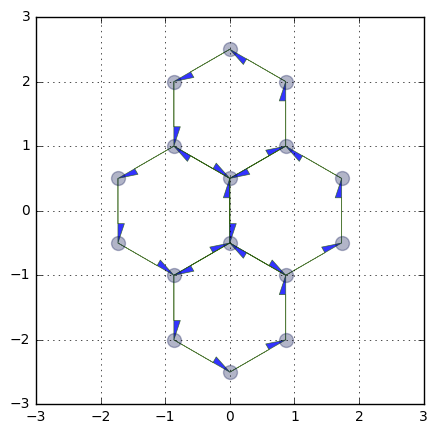

In [36]:
# Define size of tissue in an array with the number of cells in each row:
# [1,2,1] means the first row has 1 cell, second row has 2 cells, third row has 1 cell
datasets, specs = multi_faces_sheet([1,2,1])
sheet = Sheet('4_cells', datasets, specs, coords=['x', 'y'])
LanGeometry.update_all(sheet)
sheet.sanitize()

# define medial myosin phases
sheet.datasets['face']['phi'] = [0, np.pi/2, np.pi/4, 0]

# Plot it
fig, ax = sheet_view(sheet)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
fig.set_size_inches((5, 5))


In [37]:
# Initial Conditions

sheet.datasets['edge']['Myo'] = Meq
sheet.datasets['edge']['Rok'] = Req
sheet.datasets['edge']['Baz'] = Beq
sheet.datasets['edge']['Shroom'] = Seq

sheet.datasets['face']
sheet.datasets['vert']

,x,y
vert,,
0,0.00000,2.5
1,-0.86603,2.0
2,-0.86603,1.0
3,-0.00000,0.5
4,0.86603,1.0
5,0.86603,2.0
6,-1.73205,0.5
7,-1.73205,-0.5
8,-0.86603,-1.0


### Next: Define ODEs

#### Mechanical forces on vertices (total: 16 vertices):

$$ \frac{dx_{i}}{dt} = \frac{1}{\eta}\Bigg[\sum\limits_{j} f_{ij}\frac{{x_j}-{x_i}}{\left|x_j-x_i\right|} + f_{mi}e_{ci}+pe_{ni}\Bigg] $$

where $e_{ci}$ is a unit vector pointing from vertex $i$ toward the centroid of the cell and $e_{ni}$ is an outward normal vector that bisects the angle formed by the two edges meeting at vertex $i$.

$$ f_{ij} = \mu\big(l_{ij}-l_0\big)-\beta\big(m_{ij}-m^e\big) $$

$$ f_{mi} = \beta\Big[A_m\sin^2{\Big(\frac{t\pi}{T}+\phi\Big)}\Big] $$

#### Biochemistry on each edges (total: 19 edges):

$$ \frac{dm}{dt} = k_1R-k_2mB-(k_3 \exp^{-k_4f_{ij}})m $$

$$ \frac{dR}{dt}=q_r-k_r\exp^{-S}R $$

$$ \frac{dB}{dt} = q_b - k_b RB $$

#### RK-2 Solving Scheme:

$$ k_1 = f(t,y_i) $$
$$ k_2 = f\Big(t + \frac{dt}{2}, y_i + k_1\frac{dt}{2}\Big) $$
$$ y_{i+1} = y_i + k_2dt $$

In [38]:
# Differential Equations

def diff_equations(vertices,edges,faces,time):
    
    edge = edges.copy()
    vert = vertices.copy()
    face = faces.copy()
    
    # Update lengths
    coords = vert[['x','y']] # sheet.coords are ['x', 'y'], defined in multi_faces_sheet
    srce_pos = sheet.upcast_srce(coords)
    trgt_pos = sheet.upcast_trgt(coords)
    dcoords = (trgt_pos - srce_pos)
    
    # update medial force
    phi = sheet.upcast_face(face['phi'])
    fmi = beta*(Am * np.square(np.sin((time*np.pi)/period)) + phi)
    
    # update pressure force
    pressure = alpha*(restArea - sheet.upcast_face(face['area']))
    
    # update edge force
    edge['fij'] = miu*(edge['length'] - restLength) - beta*(edge['Myo'] - Meq)
    
    # face unit vectors
    face_pos = sheet.upcast_face(face[sheet.coords])
    fcoords = (face_pos - srce_pos)
    dfdx = fcoords.copy()
    f_norms = np.sqrt(np.square(dfdx).sum(axis=1))
    dfdx.divide(f_norms,axis=0)
    
    # dxdt term 1 calculations
    grad_ij = -edge[['dx','dy']]/_to_2d(edge['length'])
    grad_lij = grad_ij.multiply(edge['fij'],axis=0)
    edge.update(grad_lij) # store term_1 values as dx,dy in edge df
    
    # dxdt term 2 calculations
    edge[['medial_force_x','medial_force_y']] = dfdx.multiply(fmi, axis=0)
    
    # TODO: dxdt term 3 calculations
    edge[['p_force_x','p_force_y']] = -dfdx.multiply(pressure, axis=0)
    
    # sumdxdt terms
    term_1 = sheet.sum_srce(edge[['dx','dy']]) + sheet.sum_trgt(edge[['dx','dy']])
    term_1.columns = sheet.coords
    term_2 = sheet.sum_srce(edge[['medial_force_x','medial_force_y']])
    term_2.columns = sheet.coords
    # term_3 = sheet.sum_srce(edge[['p_force_x','p_force_y']]).values
        
    dxdt = (1/eta)*(term_1 + term_2)
    vert[['x','y']] = dxdt
        
    # update chemistry
    Baz_tmp = qb - kb*edge['Rok']*edge['Baz']
    Rok_tmp = qr - kr*edge['Rok']*np.exp(edge['Shroom'])
    Myo_tmp = k1*edge['Rok'] - k2*edge['Myo']*edge['Baz'] - (k3*np.exp(-k4*edge['fij']))*edge['Myo']

    edge['Baz'] = Baz_tmp
    edge['Rok'] = Rok_tmp
    edge['Myo'] = Myo_tmp
    
    # drop temporary cols
    edge = edge.drop(['fij'], 1)
    
    return vert.copy(), edge.copy(), face.copy()


# Calculate the normal vector pointing outwards for 3 points: p1 p2 p3
def bisector_vector(p1, p2, p3):
    l1 = np.linalg.norm(p1,p2)
    l2 = np.linalg.norm(p2,p3)
    l3 = np.linalg.norm(p3,p1)
    x = p1[0] + l1/(l1+l2)*(p3[0] - p1[0])
    y = p1[1] + l1/(l1+l2)*(p3[1] - p1[1])
    ll = np.linalg.norm([x,y],p2)
    c = (p2[0]-x)/ll
    s = (p2[1]-y)/ll
    return [c, s]


# ODE Solver

Using a Runge-Kutta 2nd order solver as in the paper:

$y_{i+1} = y_i + k_2 dt$

$t_{i+1} = t_i + dt$

Where

$ k_2 = f(t_i + \frac{dt}{2}, y_i + k_1\frac{dt}{2}) $

$ k_1 = f(t_i,y_i) $

In [39]:
# Main Loop


time = 0
dt = 0.1
max_time = 3

while time < max_time:
    # Runge-Kutta 2nd Order solver
    vert = sheet.datasets['vert'].copy()
    edge = sheet.datasets['edge'].copy()
    face = sheet.datasets['face'].copy()
    
    vert_cols = ['x', 'y']
    edge_cols = ['Baz', 'Rok', 'Myo', 'Shroom']
    face_cols = ['x','y']
    
    vert_1, edge_1, face_1 = diff_equations(vert,
                                            edge,
                                            face,
                                            time)
    
    vert_2, edge_2, face_2 = diff_equations(vert + vert_1*dt/2,
                                            edge + edge_1*dt/2,
                                            face + face_1*dt/2,
                                            time + dt/2)    
    
    vert_new = vert + vert_2*dt
    edge_new = edge + edge_2*dt
    face_new = face + face_2*dt
    
    sheet.datasets['vert'].update(vert_new[vert_cols])
    sheet.datasets['edge'].update(edge_new[edge_cols])
    sheet.datasets['face'].update(face_new[face_cols])

    LanGeometry.update_all(sheet)
    sheet.sanitize()
    time += dt    

    
    pass

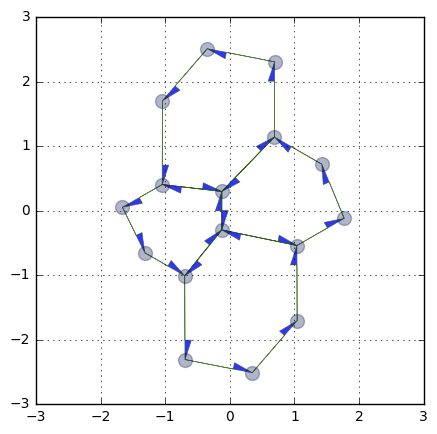

In [40]:
fig, ax = sheet_view(sheet)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
fig.set_size_inches((5, 5))